<a href="https://colab.research.google.com/github/idowujames/-Kenya-Clinical-Reasoning-Challenge/blob/main/Kenya_Clinical_Reasoning_Challenge_2-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rouge-score --quiet

  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

import nltk

# For evaluation
from rouge_score import rouge_scorer

# Exploratory Data Analysis (EDA)
## Understand patterns in the dataset beyond just text length:

1. Which clinical domains are most common

2. Which nursing competencies are represented

3. Whether Counties or Health Levels influence complexity or length

4. If certain domains have longer/shorter responses, etc.

## Why This Step Matters

- **Set Realistic Expectations**: If we know a certain clinical domain has only 5 examples, we can predict that the model will likely perform poorly on it. We won't be surprised by this "failure" later.
- **Diagnose Problems Better**: If our model generates a response that's too short, we can check if it belongs to a category (e.g., "Critical Care") that we know should have long responses. This helps us understand why the model is failing.
- **Build Trust and Ensure Fairness**: It helps us ensure our model isn't biased. What if it's great at cases from "Kiambu" county but terrible at cases from "Kakamega" because of data imbalance? We need to know this.


In [3]:
# Loading the dataset
df = pd.read_csv('cleaned_dataset.csv')

print(df.shape)
df.head()

(386, 14)


,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED,Prompt_word_count,Clinician_word_count
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...,158,47
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...,124,146
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...,128,111
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 92 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...,88,168
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...,110,137


### 1. Which clinical domains are most common

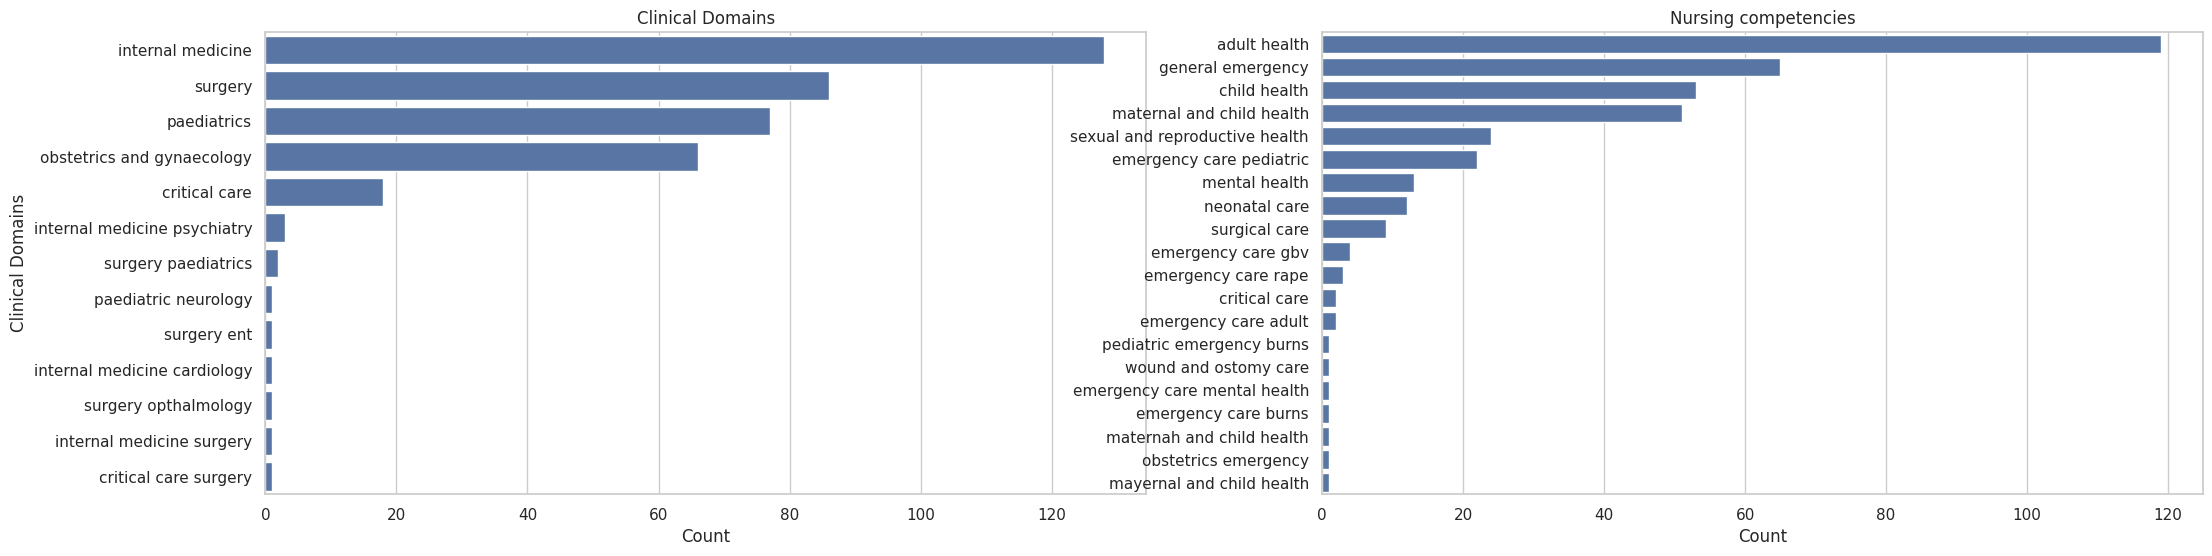

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

sns.countplot(data=df, y='Clinical Panel', order=df['Clinical Panel'].value_counts().index, ax=ax1)
ax1.set_title('Clinical Domains')
ax1.set_xlabel('Count')
ax1.set_ylabel('Clinical Domains')

sns.countplot(data=df, y='Nursing Competency', order=df['Nursing Competency'].value_counts().index, ax=ax2)
ax2.set_title('Nursing competencies')
ax2.set_xlabel('Count')
ax2.set_ylabel(' ')
plt.show()
# plt.xticks(rotation=90)

## Interpretation:
The output show us that this data is dominated by domains such as Internal Medicine, Surgery, Paediatrics, Obstetrics & Gynaecology and Critical Care. And it may not generalize well to domains such as Critical Care surgery, internal medicine surgery, surgery opthalmology,internal medicine cardiology, surgery ent an paediatric neurology, as these have very low entries in the dataset.

### 3. Do Counties or Health Levels influence complexity or length?

In [32]:
# Analysis of Response Length by Counties

df.groupby('County')['Clinician_word_count'].mean().sort_values(ascending=False)

,Clinician_word_count
County,
bungoma,122.750000
kiambu,116.859649
uasin gishu,111.769874
kakamega,101.587500
elgeiyo marakwet,99.333333


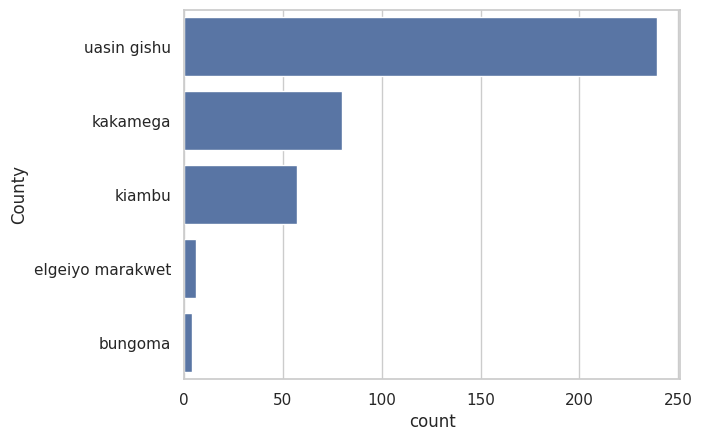

In [54]:
# Distribution of Counties
sns.countplot(data=df, y='County', order=df['County'].value_counts().index)
plt.show()

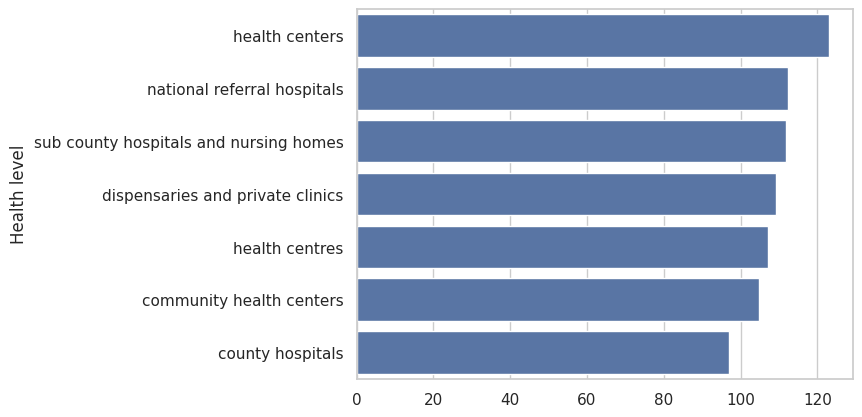

In [45]:
# Avg response length by Health Levels

health_level_order = df.groupby('Health level')['Clinician_word_count'].mean().sort_values(ascending=False)
sns.barplot(y=health_level_order.index, x=health_level_order.values, order=health_level_order.index)
plt.show()

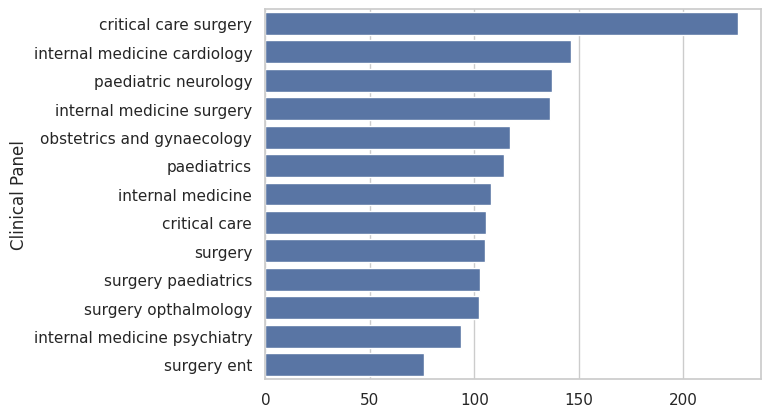

In [55]:
# Avg response length by Clinical Panel

avg_len_by_panel= df.groupby('Clinical Panel')['Clinician_word_count'].mean().sort_values(ascending=False)
sns.barplot(y=avg_len_by_panel.index, x=avg_len_by_panel.values, order=avg_len_by_panel.index)
plt.show()

## Interpretation:
It appears the Critical care surgery has the highest avg clinician response lenght. This might be because it has only one entry in the dataset thereby not spreading it's response lenght over many responses. Same can be said about all the other entries with only one or very few entries. They all have relatively high avg clinician response. Once we get to Clinical Panels(domians) with relatively high entries in the dataset, it doesn't appear to be much significant difference in clinician avg response legnth. It appears the domain do not significantly impact clinician response lenght.

Same can be said about health level. It doesn't appear that there much significant difference in avg clinician response to health level.